In [11]:
import spikeinterface.full as si
import probeinterface as pi
from pathlib import Path
import woodsort
import numpy as np 
import matplotlib.pyplot as plt
from pprint import pprint

In [12]:

# path to the recording folder (the folder containing the OpenEphys folder YYYY-MM-DD_hh-mm-ss)
session_path = '/home/avadher/Data/H7113-250604/'

# set parameters for probe
shank_groups = [0, 1] # specify which groups in the Neuroscope xml file are shanks of the probe
probe_manufacturer = "cambridgeneurotech"
probe_name = "ASSY-156-H7" 

# Set paths 
session_path = Path(session_path)
session_name = session_path.name

si.set_global_job_kwargs(n_jobs=12) 


Using XML file: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/continuous.xml


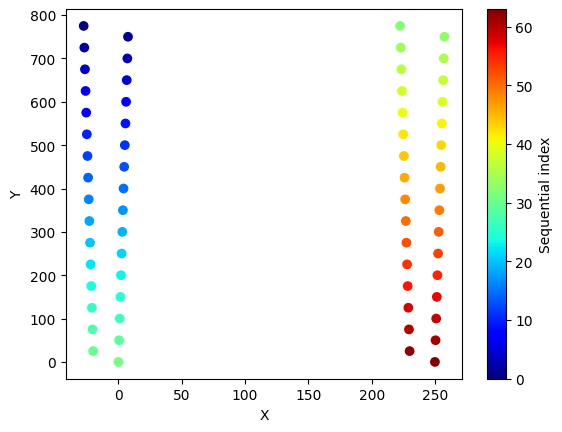


Original: mapping device_channel_indices:contact_ids
{np.int64(0): np.str_('15'),
 np.int64(1): np.str_('13'),
 np.int64(2): np.str_('7'),
 np.int64(3): np.str_('23'),
 np.int64(4): np.str_('1'),
 np.int64(5): np.str_('29'),
 np.int64(6): np.str_('3'),
 np.int64(7): np.str_('12'),
 np.int64(8): np.str_('18'),
 np.int64(9): np.str_('14'),
 np.int64(10): np.str_('24'),
 np.int64(11): np.str_('8'),
 np.int64(12): np.str_('22'),
 np.int64(13): np.str_('2'),
 np.int64(14): np.str_('28'),
 np.int64(15): np.str_('4'),
 np.int64(16): np.str_('9'),
 np.int64(17): np.str_('48'),
 np.int64(18): np.str_('27'),
 np.int64(19): np.str_('21'),
 np.int64(20): np.str_('10'),
 np.int64(21): np.str_('16'),
 np.int64(22): np.str_('0'),
 np.int64(23): np.str_('26'),
 np.int64(24): np.str_('6'),
 np.int64(25): np.str_('20'),
 np.int64(26): np.str_('31'),
 np.int64(27): np.str_('30'),
 np.int64(28): np.str_('25'),
 np.int64(29): np.str_('5'),
 np.int64(30): np.str_('11'),
 np.int64(31): np.str_('19'),
 np.in

In [13]:
### Prepare the probe based on probeinterface layout and Neuroscope mapping ###

# Neuroscope mapping denotes the sequence of recording channels in the recording file, from top to bottom of each shank and from left to right shank-wise
# Sorting according to Neuroscope order results in anatomical mapping

# Load recording and probe, preprocess and fill channel indices from Neuroscope
probe = pi.get_probe(manufacturer=probe_manufacturer, probe_name=probe_name) # pi.list_all_probes() to list all probes 

# Load Neuroscope channel mapping
channel_mapping = woodsort.neuroscope.load_neuroscope_channels(session_path)

# Get channel indices corresponding to the probe
neuroscope_channel_indices = (
    channel_mapping.loc[
        channel_mapping["channel_group"].isin(shank_groups),
        "channel_0based",
    ].tolist()
)

# sort channels based on their coordinates, top to bottom and shank-wise
sorted_coordinates_by_shank = []
for unique_id in np.unique(probe.shank_ids):
    id_indices = np.where(probe.shank_ids == unique_id)[0]
    coors = probe.contact_positions[id_indices]
    coors = coors[coors[:, 1].argsort()[::-1]]
    sorted_coordinates_by_shank.append(coors)
final_sorted_coordinates = np.vstack(sorted_coordinates_by_shank)

# Plot contact coordinates in order (color-coded)
plt.scatter(final_sorted_coordinates[:, 0], final_sorted_coordinates[:, 1], c=np.arange(len(final_sorted_coordinates)), cmap='jet')
plt.colorbar(label="Sequential index")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

# Update probe with sorted coordinates
probe.set_contacts(
    final_sorted_coordinates,
    shapes=probe.contact_shapes,
    shape_params=probe.contact_shape_params,
    plane_axes=probe.contact_plane_axes,
    contact_ids=np.arange(len(neuroscope_channel_indices)),
    shank_ids=np.sort(probe.shank_ids),  # Sorted shank_ids
)

# Run the usual preprocessing
probe.set_device_channel_indices(neuroscope_channel_indices)
recording = si.read_openephys(session_path,stream_id='0')
recording = recording.set_probe(probe, group_mode="by_shank")
recording = si.concatenate_recordings([recording])
#recording = recording.split_by("group")  # Don't split by shank for clarity (it's the same if you do)
recording = si.bandpass_filter(recording)
recording = si.detect_and_remove_bad_channels(recording)

print('\nOriginal: mapping device_channel_indices:contact_ids')
pprint(dict(zip(probe.device_channel_indices, probe.contact_ids)))

print('\nAfter removing channels: mapping device_channel_indices:contact_ids')
pprint(dict(zip(recording.get_probe().device_channel_indices, recording.get_probe().contact_ids)))


In [14]:
# Run spike sorting
sorting = si.run_sorter(
    recording=recording, 
    sorter_name='mountainsort5', 
    remove_existing_folder=True, 
    folder='/home/avadher/Data/H7113-250604/Test')

## Compute analyzer
analyzer = si.create_sorting_analyzer(
    recording=recording,
    sorting=sorting,
    format="binary_folder",
    folder='/home/avadher/Data/H7113-250604/Test',
    overwrite=True,
)

analyzer.compute({'random_spikes': {},
                          'waveforms': {},
                          'templates': {}})

write_binary_recording 
engine=process - n_jobs=12 - samples_per_chunk=30,000 - chunk_memory=7.10 MiB - total_memory=85.14 MiB - chunk_duration=1.00s
Using training recording of duration 300 sec with the sampling mode uniform
*** MS5 Elapsed time for SCHEME2 get_sampled_recording_for_training: 0.672 seconds ***
Running phase 1 sorting
Number of channels: 62
Number of timepoints: 9000000
Sampling frequency: 30000.0 Hz
Channel 0: [  4.5 450. ]
Channel 1: [  6. 600.]
Channel 2: [  2. 200.]
Channel 3: [  7.5 750. ]
Channel 4: [ 0.5 50. ]
Channel 5: [  7. 700.]
Channel 6: [-24.5 475. ]
Channel 7: [-23. 325.]
Channel 8: [-24. 425.]
Channel 9: [-21.5 175. ]
Channel 10: [-25.5 575. ]
Channel 11: [-22. 225.]
Channel 12: [-27. 725.]
Channel 13: [-20.5  75. ]
Channel 14: [-26.5 675. ]
Channel 15: [226.5 375. ]
Channel 16: [  1. 100.]
Channel 17: [  2.5 250. ]
Channel 18: [-25. 525.]
Channel 19: [-23.5 375. ]
Channel 20: [-27.5 775. ]
Channel 21: [-21. 125.]
Channel 22: [-26. 625.]
Channel 23: [-2

estimate_sparsity (workers: 12 processes):   0%|          | 0/649 [00:00<?, ?it/s]

/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/core/basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


compute_waveforms (workers: 12 processes):   0%|          | 0/649 [00:00<?, ?it/s]

In [15]:
print('\nOriginal: mapping device_channel_indices:contact_ids')
pprint(dict(zip(probe.device_channel_indices, probe.contact_ids)))

print('\nFrom Analyzer>probe: mapping device_channel_indices:contact_ids')
pprint(dict(zip(analyzer.get_probe().device_channel_indices, analyzer.get_probe().contact_ids)))

print('\nFrom Recording after sorting: mapping device_channel_indices:contact_ids')
pprint(dict(zip(analyzer.recording.get_probe().device_channel_indices, analyzer.recording.get_probe().contact_ids)))

#WHERE ARE THE INDICES BELOW COMING FROM? 
print('\nFrom Analyzer: mapping device_channel_indices:contact_ids')
pprint(analyzer.channel_ids)


Original: mapping device_channel_indices:contact_ids
{np.int64(0): np.str_('15'),
 np.int64(1): np.str_('13'),
 np.int64(2): np.str_('7'),
 np.int64(3): np.str_('23'),
 np.int64(4): np.str_('1'),
 np.int64(5): np.str_('29'),
 np.int64(6): np.str_('3'),
 np.int64(7): np.str_('12'),
 np.int64(8): np.str_('18'),
 np.int64(9): np.str_('14'),
 np.int64(10): np.str_('24'),
 np.int64(11): np.str_('8'),
 np.int64(12): np.str_('22'),
 np.int64(13): np.str_('2'),
 np.int64(14): np.str_('28'),
 np.int64(15): np.str_('4'),
 np.int64(16): np.str_('9'),
 np.int64(17): np.str_('48'),
 np.int64(18): np.str_('27'),
 np.int64(19): np.str_('21'),
 np.int64(20): np.str_('10'),
 np.int64(21): np.str_('16'),
 np.int64(22): np.str_('0'),
 np.int64(23): np.str_('26'),
 np.int64(24): np.str_('6'),
 np.int64(25): np.str_('20'),
 np.int64(26): np.str_('31'),
 np.int64(27): np.str_('30'),
 np.int64(28): np.str_('25'),
 np.int64(29): np.str_('5'),
 np.int64(30): np.str_('11'),
 np.int64(31): np.str_('19'),
 np.in

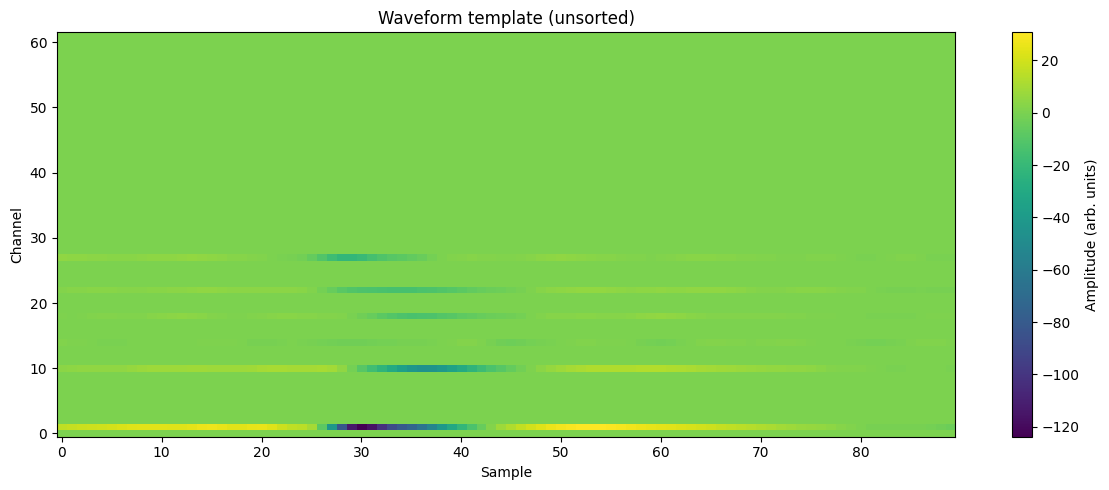

IndexError: index 62 is out of bounds for axis 0 with size 62

<Figure size 1200x500 with 0 Axes>

In [16]:
### PLOT WAVEFORMS ###

waveforms = analyzer.get_extension("templates").get_data()
cell_number = 1
wf = waveforms[cell_number,:,:].T

# Plot waveforms (unsorted)
plt.figure(figsize=(12, 5))
im = plt.imshow(wf, aspect="auto", origin="lower")
plt.ylabel("Channel")
plt.xlabel("Sample")
plt.title("Waveform template (unsorted)")
plt.colorbar(im, label="Amplitude (arb. units)")
plt.tight_layout()
plt.show()

# Plot waveforms (sorted by analyzer.channel_ids)
order = np.array(
    [int(ch.replace("CH", "")) for ch in analyzer.channel_ids],
    dtype=int
)
order = order - 1  # make 0-based
plt.figure(figsize=(12, 5))
im = plt.imshow(wf[order], aspect="auto", origin="lower")
plt.ylabel("Channel")
plt.xlabel("Sample")
plt.title("Waveform template (sorted by analyzer.channel_ids)")
plt.colorbar(im, label="Amplitude (arb. units)")
plt.tight_layout()
plt.show()

# Plot waveforms (sorted by probe mapping)
mapping = dict(zip(analyzer.get_probe().device_channel_indices, analyzer.get_probe().contact_ids))
order = sorted(mapping, key=lambda k: int(mapping[k]))

plt.figure(figsize=(12, 5))
im = plt.imshow(wf[order], aspect="auto", origin="lower")
plt.ylabel("Channel")
plt.xlabel("Sample")
plt.title("Waveform template (sorted by probe mapping)")
plt.colorbar(im, label="Amplitude (arb. units)")
plt.tight_layout()
plt.show()